In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.feature_selection
import unittest

In [34]:
cd /Users/loganroberts/Learn2Therm/ValidProt/Components

/Users/loganroberts/Learn2Therm/ValidProt/Components


In [35]:
df_original = pd.read_csv('learn2therm_sample_50k.csv')

In [36]:
categories = df_original['t_protein_desc'].value_counts()
categories = categories.iloc[categories.values > 500]
categories_dict = {item: None for item in categories.index}

list_of_cats = list(categories_dict.keys())
list_of_cats

df = df_original[df_original.t_protein_desc.isin(list_of_cats)]

In [37]:
columns_to_keep = ['bit_score','local_gap_compressed_percent_id','scaled_local_query_percent_id',
                      'scaled_local_symmetric_percent_id','query_align_len', 'query_align_cov',
                      'subject_align_len', 'subject_align_cov', 'm_protein_len', 't_protein_len', 't_protein_desc']

In [38]:
def input_cleaning_wrapper(dataframe):
    
    #check type of dataframe
    check = check_input_type(dataframe)
    
    #clean out unnecessary columns
    clean = clean_input_columns(check)
    
    #verify necessary columns are present
    verify_input = verify_input_columns(clean)
    
    #check for NaN's
    check_NANs = check_input_NANs(verify_input)
    
    #verify every protein has a pair
    verify_pairs = verify_protein_pairs(check_NANs)
    
    print('The new shape of the dataframe is:{}'.format(verify_pairs.shape))
    
    return verify_pairs

In [42]:
input_cleaned = input_cleaning_wrapper(df)

DataFrame does not have any NaN values.
Dataframe now has 23783 rows.
OK!
The new shape of the dataframe is:(23783, 11)


In [43]:
def kNN_wrapper(dataframe):
    """
    Takes dataframe and runs it through kNN model.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Pearson correlation
    -Target feature predictions
    -Parity plot
    
    """
    
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    #user inputs target feature
    target = 't_protein_desc'
    
    #define input features
    input_features = [columns for columns in dataframe]
    
    input_features.remove(target)
    
    print(input_features)

    #train the model based off data split
    model, dev_X, dev_y, test_X, test_y = train_reg(
                                        split_data(dataframe)[0], split_data(dataframe)[1], 
                                        columns=input_features, target=target
                                                   )
    
    #test the model and return predictions
    preds = test_reg(model, test_X, test_y)
    
    #plot the results of the model
    plot_regression(model, test_X, test_y)
    
    return preds

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
Model score is: 0.6485
Model score is: 0.6485


array(['ABC transporter ATP-binding protein',
       'response regulator transcription factor',
       'ABC transporter ATP-binding protein', ...,
       'SDR family oxidoreductase', 'SDR family oxidoreductase',
       'response regulator transcription factor'], dtype=object)

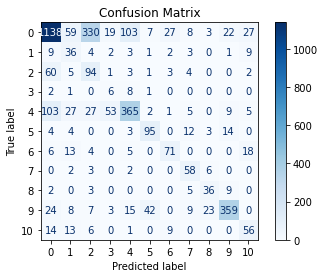

In [44]:
kNN_wrapper(input_cleaned)

In [6]:
def split_data(dataframe):
    """
    Takes dataframe and splits it into dev and test sets.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Dev and test data
    
    """
    
    #test input data type
    if "pandas.core.frame.DataFrame" not in str(type(dataframe)):
        raise ValueError("Wrong input type!")
    else:
        pass
    
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    return dev, test

In [7]:
def train_reg(dev, test, columns = [],  target = []):
    """
    Takes dev and test dataframes and trains a standard Linear Regression model with selected data.
    
    Params
    ----------
    dev, test: Pandas dataframe previously split
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Pearson correlation between each input and the output feature
    -Linear regression model
    -input test data vector (numpy array)
    -feature test vector (numpy array)
    """
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=20)
    model = model.fit(dev_X, dev_y.ravel())
    
    return model, dev_X, dev_y, test_X, test_y

In [8]:
def test_reg(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Vector of predictions based on the model (numpy array)
    -prints R2 score of the model
    -prints mean absolute error and mean squared error from model
    -prints mean, standard deviation, and relative standard deviation for the target feature
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    
    print('Model score is: {}'.format(round(score,4)))
    
    preds = model.predict(test_X)
    
    return preds

In [9]:
def plot_regression(model, test_X, test_y):
    """
    Takes a test KNN Classifier model and plots the confusion matrix.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Confusion predictions vs. observations
    -Model score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    preds = test_reg(model, test_X, test_y)
   
    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')
    

In [10]:
def check_input_type(dataframe):
    """
    Takes in input dataframe and asserts that it is the correct data type.
    """
    assert "pandas.core.frame.DataFrame" in str(type(dataframe)), 'Not a pandas dataframe!'
    
    return dataframe

def clean_input_columns(dataframe):
    """
    We want to clean certain columns out of the Pfam dataframe.
    Need to eliminate identifier columns + columns that don't have linear relationship with bit score.

    Input: Pandas dataframe (from Pfam)
    Output: Updated dataframe.
    """

    for title in dataframe:
        if title not in columns_to_keep:
            dataframe = dataframe.drop(columns = title)
        else:
            pass

    return dataframe

def verify_input_columns(dataframe):
    """
    This function raises an error is one of the columns we need for the model is not
    present in the dataframe.

    Input: Pandas dataframe.
    Output: Pandas dataframe.
    """    
    for title in columns_to_keep:

        if title not in dataframe:
            raise KeyError
        else:
            pass

    return dataframe

def check_input_NANs(dataframe):
    """
    Checks for NaN values in input dataframe. Removes rows with NaN values present.

    Input: Pandas dataframe
    Output: Pandas dataframe

    """
    has_nan = dataframe.isna().any().any()
    nan_rows = dataframe[dataframe.isna().any(axis=1)]

    if has_nan:
        print('Dataframe has {} rows with NaN values!'.format(len(nan_rows)))
    else:
        print("DataFrame does not have any NaN values.")

    #Drop rows with NaN's
    dataframe = dataframe.dropna()
    print('Dataframe now has {} rows.'.format(len(dataframe)))

    return dataframe

def verify_protein_pairs(dataframe):
    """
    Checks that input data has two protein sequences. Will need to generalize this function other data sets 
    to simply make sure two sequences are entered. Code below is for our protein database
    """
    assert 'm_protein_len' in dataframe, 'Dataframe missing mesophillic sequence!'
    assert 't_protein_len' in dataframe, 'Dataframe missing thermophillic sequence!'

    print('OK!')
    return dataframe

